In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from tensorflow import keras
import wandb
from wandb.keras import WandbCallback

In [2]:
plt.style.use('ggplot')

In [3]:
seed = 13

In [4]:
(x_train, g_train), (x_test, g_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Single Layer Network on the Hitters Data

In [5]:
df_hit = pd.read_csv('../data/hitters.csv')
df_gitter = df_hit.dropna()

In [6]:
df_gitter.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


In [7]:
df_gitter.shape

(263, 20)

In [8]:
test_id = df_gitter.sample(frac=0.33, random_state=seed).index
train_id_bool = ~df_gitter.index.isin(test_id)
gitter_train, gitter_test = df_gitter.loc[train_id_bool, :], df_gitter.loc[test_id, :]

### Linear Regression

In [9]:
# https://stackoverflow.com/questions/35518477/statsmodels-short-way-of-writing-formula
def formula_from_cols(df: pd.DataFrame, y: str) -> str:
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [10]:
gitter_formula = formula_from_cols(df_gitter, 'Salary')
print(gitter_formula)

Salary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists + Errors + NewLeague


In [11]:
l_fit = smf.ols(gitter_formula, data=gitter_train).fit()
l_pred = l_fit.predict(gitter_test).values
lm_gitter_mae = np.mean(np.abs(l_pred - gitter_test.Salary.values))
print(lm_gitter_mae)

242.99282793560906


### Lasso Regression

In [12]:
def get_x_y_gitter(df: pd.DataFrame) -> Tuple:
    gitter_obj_col = list(df_gitter.select_dtypes('object').columns)
    x = pd.get_dummies(df, columns = gitter_obj_col, drop_first=True)\
             .drop('Salary', axis=1)
    y = df['Salary']
    return x, y

In [13]:
gitter_train_x, gitter_train_y = get_x_y_gitter(gitter_train)
gitter_test_x, gitter_test_y = get_x_y_gitter(gitter_test)

In [14]:
def scale_to_df(df: pd.DataFrame, 
                std_scale: StandardScaler) -> pd.DataFrame:
    return pd.DataFrame(std_scale.transform(df), columns = list(df.columns))

In [15]:
std_scale = StandardScaler()
_ = std_scale.fit(gitter_train_x)
gitter_train_x_scaled = scale_to_df(gitter_train_x, std_scale)
gitter_test_x_scaled = scale_to_df(gitter_test_x, std_scale)

In [16]:
cv_fit = LassoCV(cv=5, random_state=seed).fit(gitter_train_x_scaled, 
                                              gitter_train_y)

In [17]:
c_pred = cv_fit.predict(gitter_test_x_scaled)
np.mean(np.abs(gitter_test_y - c_pred))

223.45749081018576

### Neural Network

In [18]:
mod_nn = keras.models.Sequential([
    keras.Input(shape=(gitter_train_x_scaled.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(1)
]
)

opt = keras.optimizers.RMSprop()
mod_nn.compile(loss='mse',
               optimizer=opt,
               metrics=['mean_absolute_error'])

mod_nn.fit(gitter_train_x_scaled, gitter_train_y, epochs=1500,
           batch_size=32, validation_data=(gitter_test_x_scaled, gitter_test_y), 
           verbose=0)


2021-08-24 14:49:42.908986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-24 14:49:42.969255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [19]:
def plot_history(history_dict: dict, metrics_name: str) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    df_history = pd.DataFrame(history_dict)

    for i, name in zip(range(2), [metrics_name, 'loss']):
        axes[i].plot(df_history[name], label='train')
        axes[i].plot(df_history[f'val_{name}'], label='validation')
        axes[i].set_ylabel(name)
        axes[i].legend()

    plt.show()

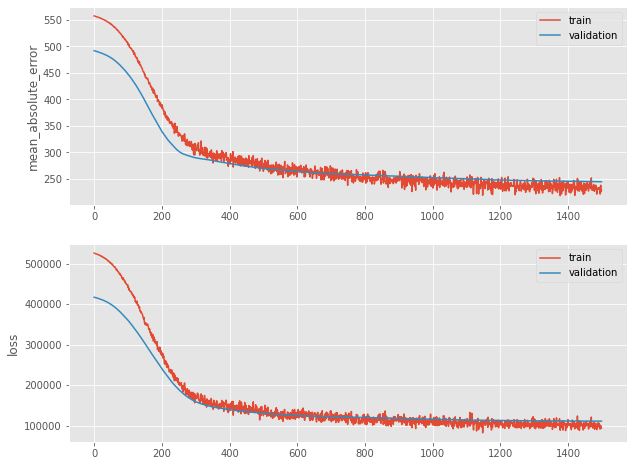

In [20]:
plot_history(mod_nn.history.history, 'mean_absolute_error')

In [21]:
n_pred = mod_nn.predict(gitter_test_x_scaled).reshape(-1)
np.mean(np.abs(gitter_test_y - n_pred))

244.71971154083602

## MultiLayer Network on the MNIST Digit Data

In [23]:
run = wandb.init(mode='online', project='keras-demo', reinit=True,
                 name='one_run',
                 config={
                     "epochs": 30,
                     "batch_size": 128,
                     "loss_function": "categorical_crossentropy"
                 })
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wpan (use `wandb login --relogin` to force relogin)


In [24]:
config

{'epochs': 30, 'batch_size': 128, 'loss_function': 'categorical_crossentropy'}

In [25]:
(x_train, g_train), (x_test, g_test) = keras.datasets.mnist.load_data()

In [26]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
y_train = keras.utils.to_categorical(g_train)
y_test = keras.utils.to_categorical(g_test)

In [27]:
x_train = x_train / 255
x_test  = x_test / 255

In [28]:
model_nn = keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_dim=784),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(10, activation='softmax')
]
)

In [29]:
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_nn.compile(loss=config.loss_function,
                 optimizer=keras.optimizers.RMSprop(), metrics='accuracy')

In [31]:
model_nn.fit(x_train, y_train, epochs=config.epochs,
           batch_size=config.batch_size, validation_split=0.2,
           callbacks=[WandbCallback()])

Epoch 1/30
375/375 [==============================] - 2s 4ms/step - loss: 0.4302 - accuracy: 0.8701 - val_loss: 0.1602 - val_accuracy: 0.9534
Epoch 2/30
375/375 [==============================] - 2s 4ms/step - loss: 0.1984 - accuracy: 0.9405 - val_loss: 0.1231 - val_accuracy: 0.9645
Epoch 3/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1556 - accuracy: 0.9548 - val_loss: 0.1095 - val_accuracy: 0.9694
Epoch 4/30
375/375 [==============================] - 1s 3ms/step - loss: 0.1277 - accuracy: 0.9620 - val_loss: 0.1013 - val_accuracy: 0.9718
Epoch 5/30
375/375 [==============================] - 1s 4ms/step - loss: 0.1150 - accuracy: 0.9656 - val_loss: 0.0982 - val_accuracy: 0.9734
Epoch 6/30
375/375 [==============================] - 1s 4ms/step - loss: 0.1026 - accuracy: 0.9701 - val_loss: 0.0929 - val_accuracy: 0.9760
Epoch 7/30
375/375 [==============================] - 1s 4ms/step - loss: 0.0969 - accuracy: 0.9720 - val_loss: 0.0901 - val_accuracy: 0.9755
Epoch 